In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import tensorflow as tf

# **1. Load and transform the dataset**


In [2]:
image_dir = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(image_dir.glob(r'**/*.png'))
#print(filepaths)
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
df = df[df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [3]:
df.head(3)

,Filepath,Label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Label', ylabel='count'>

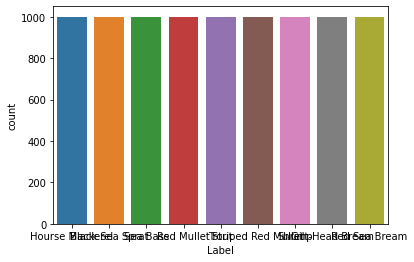

In [4]:
import seaborn as sns
sns.countplot(df["Label"])

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Label'])
df['Label'] = le.transform(df['Label'])
print(le.classes_)

['Black Sea Sprat' 'Gilt-Head Bream' 'Hourse Mackerel' 'Red Mullet'
 'Red Sea Bream' 'Sea Bass' 'Shrimp' 'Striped Red Mullet' 'Trout']


In [6]:
df.head()

,Filepath,Label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,2
1,../input/a-large-scale-fish-dataset/Fish_Datas...,2
2,../input/a-large-scale-fish-dataset/Fish_Datas...,2
3,../input/a-large-scale-fish-dataset/Fish_Datas...,2
4,../input/a-large-scale-fish-dataset/Fish_Datas...,2


# 2.Create Tensorflow input pipeline 

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((df["Filepath"],df["Label"]))

2022-01-19 05:42:59.214047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 05:42:59.354307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 05:42:59.355067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 05:42:59.358904: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
def get_train_val_test_split(ds,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size=int(ds_size*0.8)
    val_size=int(ds_size*0.1)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_train_val_test_split(dataset)

In [10]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

7200
900
900


In [11]:
def load_images(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,(224,224))
    return image, label
def augment(image, label): 
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
    return image, label

In [12]:
BATCH_SIZE=32
train_ds = (train_ds
    .shuffle(len(train_ds)*100,seed=42)
    .map(load_images)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
batch = next(iter(train_ds))

2022-01-19 05:43:02.070119: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 05:43:02.939507: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
test_ds =(test_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))
val_ds =(val_ds
         .shuffle(len(test_ds)*100)
         .map(load_images)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))

# 3.Visiualize augmented image

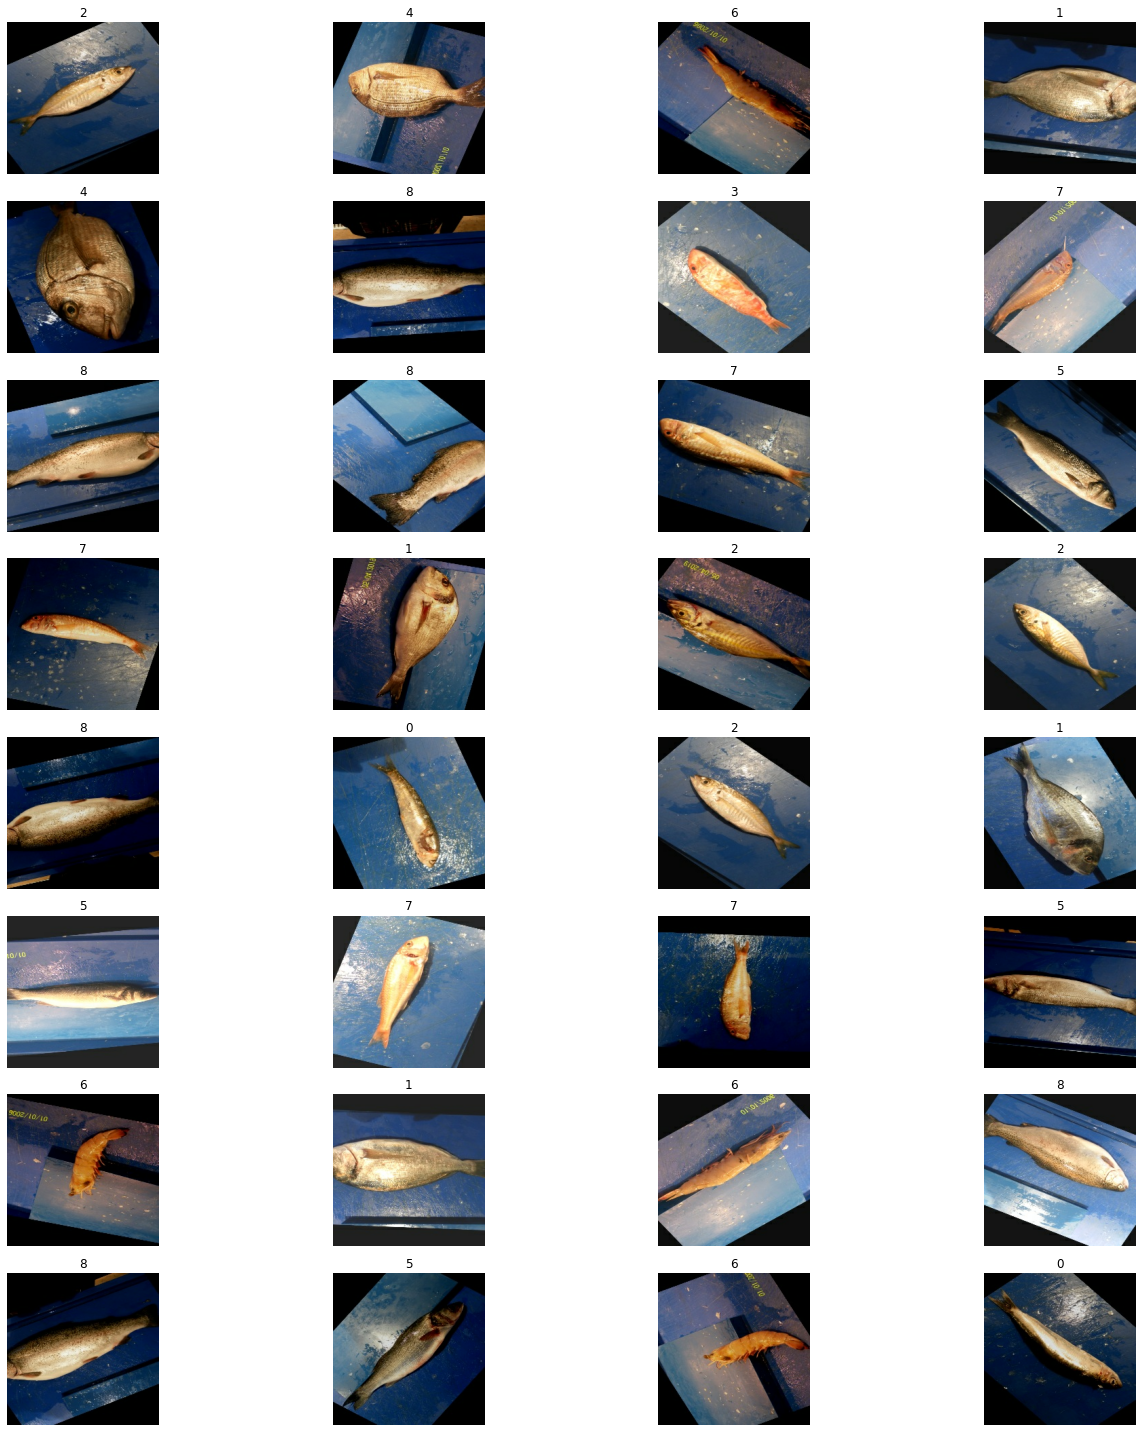

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))

# loop over the batch size
for i in range(0, BATCH_SIZE):
	# grab the image and label from the batch
	(image, label) = (batch[0][i], batch[1][i])
	# create a subplot and plot the image and label
	ax = plt.subplot(8, 4, i + 1)
	plt.imshow(image)
	plt.title(label.numpy())
	plt.axis("off")
# show the plot
plt.tight_layout()
plt.show()

# 4. Build model 

In [15]:
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Activation, Flatten,Conv2D,MaxPooling2D, BatchNormalization

In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(32, activation='relu')(pretrained_model.output)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model =Model(inputs=inputs, outputs=outputs)



In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [19]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.001, patience=2,restore_best_weights=True)
    ]
  )

Epoch 1/15


2022-01-19 05:43:12.192039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - 118s 488ms/step - loss: 0.6082 - accuracy: 0.8050 - val_loss: 0.1581 - val_accuracy: 0.9533
Epoch 2/15
225/225 [==============================] - 8s 36ms/step - loss: 0.1848 - accuracy: 0.9486 - val_loss: 0.1027 - val_accuracy: 0.9689
Epoch 3/15
225/225 [==============================] - 8s 34ms/step - loss: 0.1206 - accuracy: 0.9660 - val_loss: 0.0804 - val_accuracy: 0.9711
Epoch 4/15
225/225 [==============================] - 8s 34ms/step - loss: 0.0830 - accuracy: 0.9765 - val_loss: 0.0933 - val_accuracy: 0.9722
Epoch 5/15
225/225 [==============================] - 8s 35ms/step - loss: 0.0749 - accuracy: 0.9778 - val_loss: 0.0963 - val_accuracy: 0.9711
Epoch 6/15
225/225 [==============================] - 8s 35ms/step - loss: 0.0614 - accuracy: 0.9819 - val_loss: 0.0814 - val_accuracy: 0.9733
Epoch 7/15
225/225 [==============================] - 8s 34ms/step - loss: 0.0477 - accuracy: 0.9876 - val_loss: 0.0480 - val_accuracy: 0.9867
Epoch 8

# 5.Evaluate

In [21]:
model.evaluate(test_ds)

29/29 [==============================] - 9s 319ms/step - loss: 0.0818 - accuracy: 0.9789


[0.08183864504098892, 0.9788888692855835]

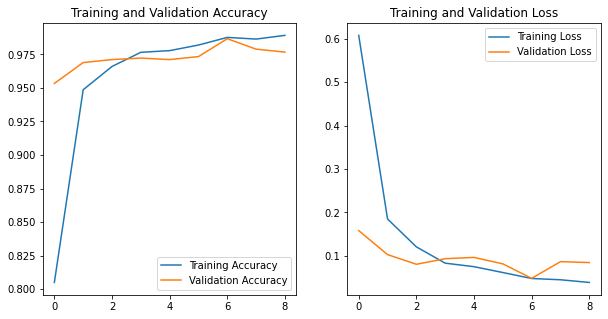

In [22]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [23]:
plt.figure(figsize=(15,15))
y_true=[]
y_pred=[]
for img, label in test_ds:
    prediction=model.predict(img)
    label=label.numpy()
    for i in range(len(label)):
        y_true.append(label[i])
    for i in range(len(prediction)):
        label_predicted=np.argmax(prediction[i])        
        y_pred.append(label_predicted)
    
    
   

<Figure size 1080x1080 with 0 Axes>

Text(69.0, 0.5, 'Truth')

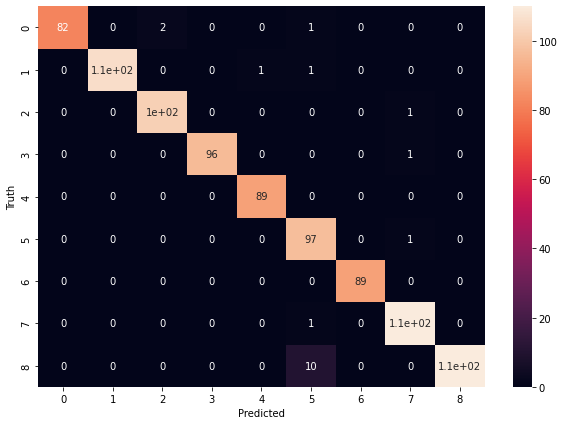

In [24]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(le.inverse_transform(y_true), le.inverse_transform(y_pred))
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')